Dataset - Generative Dog Images

Učitavanje podataka

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p" -O data.zip && rm -rf /tmp/cookies.txt

--2022-09-11 19:18:37--  https://docs.google.com/uc?export=download&confirm=t&id=1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p
Resolving docs.google.com (docs.google.com)... 142.251.12.100, 142.251.12.139, 142.251.12.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3f8ihuh2d3qi1cr025t3kl7fifkd3kh0/1662923850000/06049624160957438625/*/1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p?e=download&uuid=8ca486d1-9566-447b-ad09-2f1a3bf6131c [following]
--2022-09-11 19:18:38--  https://doc-14-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3f8ihuh2d3qi1cr025t3kl7fifkd3kh0/1662923850000/06049624160957438625/*/1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p?e=download&uuid=8ca486d1-9566-447b-ad09-2f1a3bf6131c
Resolving doc-14-64-docs.googleusercontent.com (doc-14-64-docs.googleusercontent.com)... 172.217.194.132,

In [ ]:
import os

!mkdir '../input'
print(os.listdir("../input"))

[]


In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: Annotation.zip          
  inflating: all-dogs.zip            


In [ ]:
import zipfile

!mkdir '../input/annotation'

with zipfile.ZipFile("Annotation.zip","r") as zip_ref:
    zip_ref.extractall("../input/annotation")

In [ ]:
!mkdir '../input/all-dogs'

with zipfile.ZipFile("all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("../input/all-dogs")

Generative Adversarial Network (GAN)

GAN predstavlja framework za procenjivanje generativnih modela putem adversarijalnog(kontradiktornog) procesa, u kojem se istovremeno treniraju dva modela: generativni model G koji obuhvata distribuciju podataka i diskriminativni model D koji procenjuje verovatnoću da uzorak potiče iz skupa podataka za trening pre nego iz generativnog modela G. 

 Osobine GAN-a

Generative (Generativna)
Model kao ulaz prima nasumične šumove (noise), a kao izlaz generiše fotografiju.
Adversarial (Kontradiktorna)
Ova osobina se ogleda u postojanju diskriminatora kao "protivnika" generatoru. Generator pokušava da izgeneriše lažnu fotografiju koju će diskriminator prepoznati kao pravu, a diskriminator pokušava da otkrije tu lažnu fotografiju. Tokom ovog procesa oba modela se unapređuju kako bi što bolje uspeli da izgenerišu/otkriju lažnu fotografiju.

GAN se rapidno i na zanimljiv način razvija donoseći modele koji generišu realistične primere fotografija koja god da je tema u pitanju.

Najčešće se koristi za kreiranje super-resolution verzije slike koja predstavlja ulaz, kreiranje umetnosti  i translacije image-to-image gde istu fotografiju prevodi npr. dan u noć.



Network (Mreža)
I diskriminator i generator predstavljaju neuronske mreže.






Nakon što smo importovali set podataka za trening potrebno je da importujemo sve neophodne biblioteke koje ćemo koristiti.


In [ ]:
import numpy as np 
import pandas as pd

import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
dataroot = '../input/all-dogs'
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1
ComputeLB = False
DogsOnly = True


   * dataroot - Putanja do dataset foldera.
   * workers - Broj worker thread-ova za učitavanje podataka preko DataLoader-a
   * batch_size - Veličina skupa koji će se koristiti u treniranju modela. Istraživanja pokazuju da je najbolje koristiti 128
   * image_size - Veličina fotografije koja se koristi u treniranju. Implementacija je urađena za fotografije veličine 64x64. Ukoliko želimo drugu veličinu implementacija D i G se mora menjati.
   * nc - Broj kanala za boje u fotografijama. Za fotografije u boji ovo će biti 3
   * nz - Dužina latentnog vektora
   * ngf - Odnosi se na dubinu feature mapa koje se prenose kroz generator
   * ndf - Postavalja dubinu feature mapa koje se prenose kroz generator
   * num_epochs - Broj epoha za treniranje. Duže treniranje će dati bolje rezultate, ali će i dosta duže trajati
   * lr - Stopa učenja za treniranje. U DCGAN naučnom radu rečeno je da bi ovaj broj trebao biti 0.0002
   * beta1 - Beta1 hiperparametar za Adam optimizatore. U DCGAN naučnom radu rečeno je da bi ovaj broj trebao biti 0.5
   * ngpu - Broj dostupnih GPU-ova. Ako je ovaj broj 0 kod će se izvršavati u CPU modu, u suprotnom će se izvršavati na onoliko GPU-ova koliko je definisano


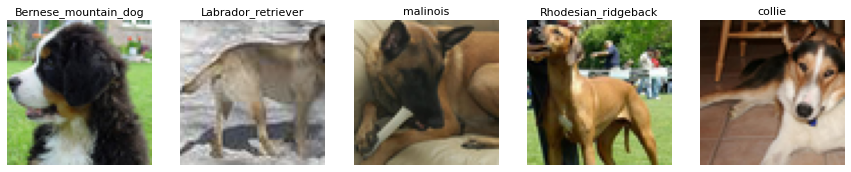

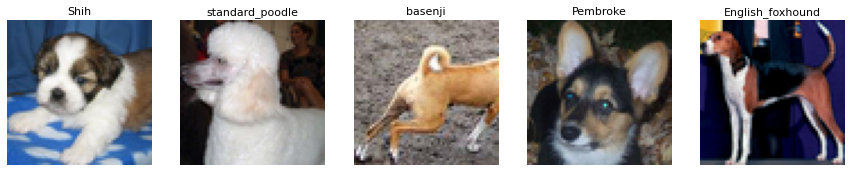

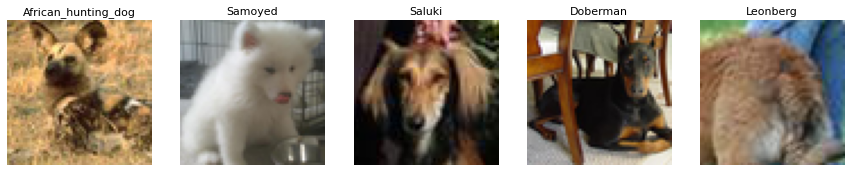

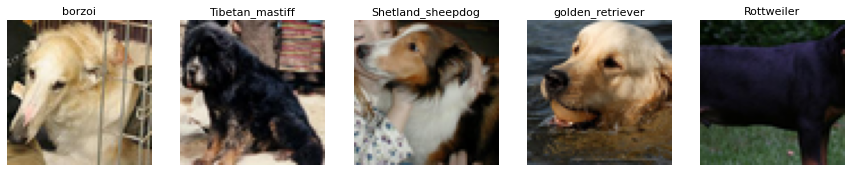

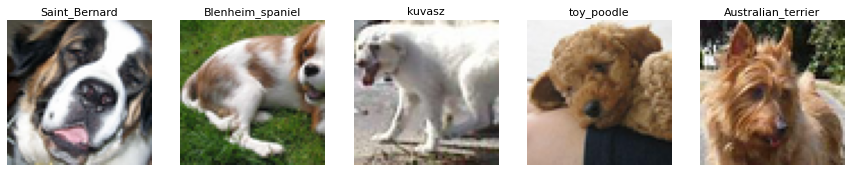

In [ ]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
IMAGES = IMAGES[::5]
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# Sečenje fotografije uz pomoć anotacija, kako bi se dobili samo psi
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# random sečenje fotografija
else:
    x = np.random.choice(np.arange(20579),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((64,64), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# prikaz isečenih fotografija
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

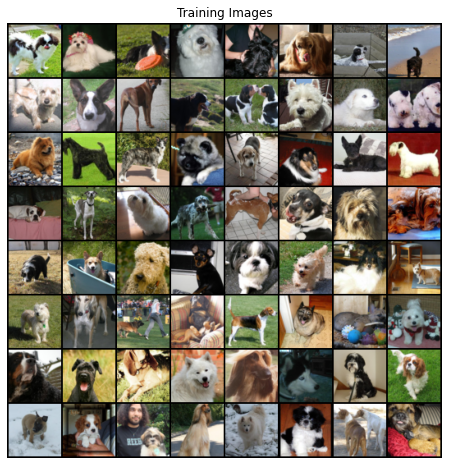

In [ ]:
# učitavanje dataseta
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Nakon učitavanja dataseta i njegove obrade može se implementirati DCGAN model. U nastavku je implementiran DCGAN kroz nekoliko faza:
1.   Inicijalizacija težina
2.   Definisanje Generatora
3.   Definisanje Diskriminatora
4.   Definisanje funkcije gubitka i optimizator
5.   Treniranje
6.   Generisanje fotografiija






Inicijalizacija težina
Prilikom DCGAN istraživanja, 
autori su zaključili da sve težine modela treba da budu random inicijalizovane iz normalne distribucije sa parametrima mean = 0, stdev = 0.02.
Funkcija weights_init uzima inicijalizovani model kao ulaz i reinicijalizuje sve konvolucijske, konvoluciono-transpozicione i batch norm slojeve da zadovolji kriterijume. Ova funkcija se primenjuje na modele odmah nakon inicijalizacije.

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.normal_(m.bias.data, 0)

Generator G je dizajniran da mapira latentni vektor prostora (z) u prostor podataka. Pošto su naši podaci fotografije, konvertovanje z u prostor podataka znači kreirati RGB fotografiju istih dimenzija kao naši trening podaci (npr. 3x64x64).

U praksi, ovo je postignuto pomoću serije dvodimenzionih konvolucijskih transpozicionih slojeva, svaki uparen sa 2D batch normalizacionim slojem i ReLu aktivacijom.

Izlaz iz generatora se pušta kroz tanh funkciju kako bi se vratio u opseg ulaznih podataka [-1, 1].

Bitno je uočiti postojanje postojanje batch norm funkcija nakon conv-transpose slojeva, jer je ovo jedan od najznačajnijih doprinosa DCGAN istraživanja.


In [ ]:
# definisanje generatora (2d conv-transpose -> batch norm -> relu -> (4 konvolucije))
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Diskriminator D
je binarna klasifikaciona mreža koja uzima fotografiju kao ulaz i na izlazu daje verovatnoću da je ulazna fotografija prava (da nije generisana).
 Ovde, D uzima 3x64x64 ulaznu fotografiju, procesuira je kroz seriju Conv2d, BatchNorm2d, LeakyReLU slojeva i na izlazu daje verovatnoću uz pomoć Sigmoid aktivacione funkcije.
 Ova arhitektura može biti proširena sa još slojeva ukoliko je to potrebno.

In [ ]:
# definisanje diskriminatora (2d conv -> batch norm -> leaky relu (4 konvolucije) -> sigmoid funkcija za verovatnoću)
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Kada su definisani generator i diskriminator,
možemo specifirati kako će oni učiti, kroz funkcije gubitka i optimizatore. Ovde se koristi **binary cross entropy loss (BCELoss)** funkcija koja je u pytorch-u definisana kao:

`ℓ(x, y) = L = {l1, …, lN}^⊤,`

`ln= −[yn ⋅ logxn + (1 − yn) ⋅ log(1−xn)]`

Ova funkcija omogućava izračunavanje obe logaritamske komponente (npr. log(D(x)) i log(1 - D(G(z))) ).
Možemo specificirati koji deo BCE jednačine ćemo koristiti sa y ulazom. Ovo će biti izvršeno kroz petlju treniranja. Izmenom y parametra biramo koju komponentu BCE-a želimo da izračunamo.

Dalje, želimo da definišemo labelu za prave fotografije sa 1, dok za izgenerisane želimo da koristimo 0.
Ove labele će biti korišćene pri izračunavanju gubitka diskriminatora i generatora (ovo je takođe i konvencija u originalnom GAN istraživanju).
Na kraju, definišemo dva odvojena optimizatora, po jedan za diskriminator i generator. Kao što je navedeno u DCGAN istraživanju, oba će koristiti optimizator Adam sa parametrima:

```
learning rate = 0.0002 i
beta1 = 0.5
```

Za čuvanje napretka učenja, generisaćemo fiksni skup latentnih vektora koji se uzimaju iz Gausove raspodele (npr. **fixed_noise**).
U petlji treniranja, periodično ćemo unositi ovaj fixed_noise u generator, i tokom iteracija ćemo videti fotografije generisane iz ovog šuma.

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Treniranje

Vrlo je bitno paziti na hiperparametre, jer pogrešna vrednost za njihova podešavanja mogu dovesti do pucanja programa bez ikakvog objašnjena.

Ovde ćemo pažljivo pratiti Algoritam 1 iz Goodfellow-ovog istraživanja, pridržavajući se najboljih praksi koje su prikazane u ovom [repozitorijumu](https://github.com/soumith/ganhacks).

Treniranje je podeljeno u dva glavna koraka. 

 **Korak 1 - Treniranje diskriminatora**

Cilj treniranja diskriminatora jeste da maksimizuje verovatnoću da pogodi klasifikaciju fotografije da li je prava ili lažna.
Želimo da ažuriramo diskriminator tako što ćemo podići njegov stohastički gradijent.
Drugim rečima, želimo da maksimizujemo

```
log(D(x)) + log(1 − D(G(z)))
```
Zbog preporuka sa [ganhacks-a](https://github.com/soumith/ganhacks), računanje će se izvršiti u dva koraka. 
Prvo, konstruisaćemo skup uzoraka pravih fotografija iz trening seta, proslediti ih kroz diskriminator, izračunati gubitak (**log(D(x))**), zatim izračunati gradijent u prolasku unazad.
Drugo, konstruisaćemo skup lažnih fotografija pomoću generatora, proslediti ovaj skup kroz diskirminator, izračunati gubitak (**log(1 - D(G(z)))**), i akumuliraćemo gradijente kroz prolaske unazad.
Kada su gradijenti prikupljeni iz oba koraka (iz skupova pravih i lažnih fotografija), optimizovaćemo diskriminator.

**Korak 2 - Treniranje generatora**

Kao što je navedeno u originalnom istraživanju, želimo da treniramo generator tako što ćemo minimizovati log(1 - D(G(z))) u pokušaju da generišemo bolje lažne fotografije.
Ian Goodfellow je ukazao na to da ova metoda ne daje dobre rezultate (gradijente), pogotovo rano u procesu učenja.
Kao rešenje, umesto toga ćemo hteti da maksimizujemo log(D(G(z))).
U kodu, ovo će se izvesti kroz klasifikaciju izlaza iz generatora iz prvog koraka pomoću diskriminatora, izračunavanje gubitka generatora, izračunavanje gradijenta generatora u prolasku unazad i konačno, ažuriranje parametara generatora u koraku optimizacije.

Na kraju svake epohe, prosledićemo fixed_batch skup generatoru kako bismo mogli vizuelno pratiti napredak treniranja generatora. 
Statistike treniranja koje se prate su:

* **Loss_D** - gubitak diskriminatora koji se izračunava kao suma svih gubitaka za skupove pravih i lažnih fotografija 
`(log(D(x))+log(D(G(z)))`

* **Loss_G** - gubitak generatora izračunat kao `log(D(G(z)))`

* **D(x)** - prosečan izlaz (u skupu) iz diskriminatora za skup pravih fotografija. Vrednost bi trebala na početku biti oko 1 i teoretski, kako generator napreduje, trebala bi konvergirati ka vrednosti 0.5.

* **D(G(z))** - prosečan izlaz za skup lažnih slika. Prva vrednost je pre nego što je diskriminator ažuriran, a druga vrednost nakon ažuriranja.
Ova vrednost bi na početku trebala biti oko 0 i teoretski, kako generator napreduje, trebala bi konvergirati ka vrednosti 0.5.

In [ ]:
# Lista za praćenje progresa
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# Za svaku epohu
for epoch in range(num_epochs):
    # Za svaki skup u dataloaderu
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Treniranje sa skupom pravih fotografija
        netD.zero_grad()
        # Formatiranje skupa
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        # Prosleđivanje skupa pravih fotografija kroz D
        output = netD(real_cpu).view(-1)
        # Izračunati gubitak na skupu pravih fotografija
        errD_real = criterion(output, label)
        # Izračunati gradijente D u prolasku unazad
        errD_real.backward()
        D_x = output.mean().item()

        ## Treniranje sa skupom lažnih fotografija
        # Generisanje skupa latentnih vektora
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generisanje skupa lažnih slika pomoću G
        fake = netG(noise)
        label.fill_(fake_label)
        # Klasifikacija skupa lažnih slika pomoću D
        output = netD(fake.detach()).view(-1)
        # Izračunati gubitak D u skupu lažnih slika
        errD_fake = criterion(output, label)
        # Izračunati gradijente D u skupu lažnih slika
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Sumiranje gradijenata iz skupova pravih i lažnih slika
        errD = errD_real + errD_fake
        # Ažuriranje D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) # labela za lažne fotografije će biti labela pravih fotografija za generator
        # Zbog ažuriranja D, izvrši prolazak unapred za skup lažnih slika kroz D
        output = netD(fake).view(-1)
        # Izračunati gubitak G baziran na ovom izlazu
        errG = criterion(output, label)
        # Izračunati gradijente G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Ažuriranje G
        optimizerG.step()

        # Statistika izlaza treniranja
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Čuvanje gubitka za plotovanje kasnije
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Provera generatora čuvanjem izlaza G uz fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/161]	Loss_D: 1.7864	Loss_G: 7.0564	D(x): 0.3625	D(G(z)): 0.4428 / 0.0010
[0/100][50/161]	Loss_D: 0.5531	Loss_G: 10.0474	D(x): 0.7371	D(G(z)): 0.0000 / 0.0000
[0/100][100/161]	Loss_D: 0.7633	Loss_G: 1.0824	D(x): 0.5893	D(G(z)): 0.0734 / 0.3664
[0/100][150/161]	Loss_D: 0.6301	Loss_G: 4.6410	D(x): 0.9202	D(G(z)): 0.3547 / 0.0153
[1/100][0/161]	Loss_D: 1.6780	Loss_G: 9.4686	D(x): 0.9777	D(G(z)): 0.7587 / 0.0001
[1/100][50/161]	Loss_D: 0.3627	Loss_G: 4.3112	D(x): 0.7556	D(G(z)): 0.0233 / 0.0157
[1/100][100/161]	Loss_D: 0.5103	Loss_G: 5.3410	D(x): 0.9458	D(G(z)): 0.3418 / 0.0063
[1/100][150/161]	Loss_D: 0.7105	Loss_G: 3.4742	D(x): 0.6915	D(G(z)): 0.2229 / 0.0434
[2/100][0/161]	Loss_D: 0.5682	Loss_G: 4.0866	D(x): 0.9294	D(G(z)): 0.3543 / 0.0228
[2/100][50/161]	Loss_D: 1.0163	Loss_G: 5.0075	D(x): 0.8435	D(G(z)): 0.5179 / 0.0105
[2/100][100/161]	Loss_D: 0.3888	Loss_G: 2.2095	D(x): 0.7437	D(G(z)): 0.0410 / 0.1251
[2/100][150/161]	Loss_D: 0.4120	Loss_G: 3.9833	

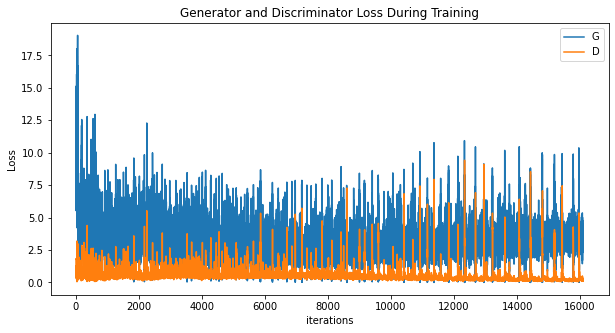

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Izgenerisane fotografije

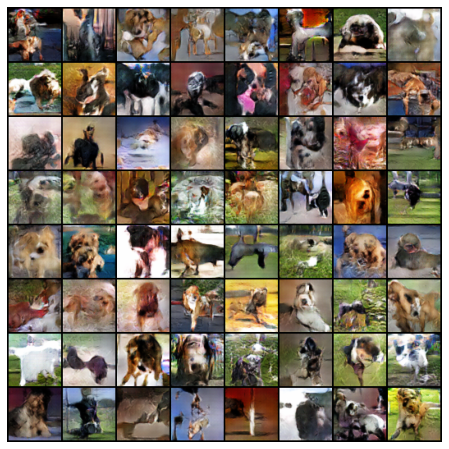

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]

In [ ]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')
print("Done")

Done


https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

https://arxiv.org/pdf/1406.2661.pdf

https://en.wikipedia.org/wiki/Generative_adversarial_network
